# Pruning Autoencoder 3D (voxel)

### Convert data

This code works on 3D voxel data in the format of .asc or .txt. In case you have a 3D object in different format you can use this website for conversion https://drububu.com/miscellaneous/voxelizer/?out=obj 

In [ ]:
!pip install pptk PyntCloud
!pip install voxelfuse

     |████████████████████████████████| 24.8 MB 1.4 MB/s 
     |████████████████████████████████| 346 kB 59.4 MB/s 
     |████████████████████████████████| 63.0 MB 1.2 MB/s 
     |████████████████████████████████| 992 kB 29.9 MB/s 
     |████████████████████████████████| 15.1 MB 34.8 MB/s 
     |████████████████████████████████| 163 kB 70.0 MB/s 
     |████████████████████████████████| 127 kB 75.9 MB/s 
     |████████████████████████████████| 8.3 MB 49.9 MB/s 
     |████████████████████████████████| 15.7 MB 30.1 MB/s 
     |████████████████████████████████| 3.3 MB 60.8 MB/s 
     |████████████████████████████████| 265 kB 70.9 MB/s 
     |████████████████████████████████| 38.1 MB 324 kB/s 
     |████████████████████████████████| 8.6 MB 59.6 MB/s 
     |████████████████████████████████| 58 kB 7.4 MB/s 
     |████████████████████████████████| 428 kB 71.7 MB/s 
     |████████████████████████████████| 395 kB 80.7 MB/s 
     |████████████████████████████████| 129 kB 82.9 MB/s 
     |████████

In [ ]:
%matplotlib notebook 
%matplotlib inline 


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pptk 
import numpy as np
import pandas as pd
from pyntcloud import PyntCloud



In [ ]:
import numpy as np

#### CHANGE THE PATH OF THE FILE HERE
point_cloud = np.loadtxt("/content/drive/MyDrive/data/Artathon_data/pieta_xyz.asc")
####

point_cloud.shape
point_cloud[1]

array([316.,  21., 328.])

In [ ]:
from pyntcloud import PyntCloud
new_df = pd.DataFrame(data=point_cloud, columns=['x','y','z'])
cloud = PyntCloud(new_df)
cloud

PyntCloud
696230 points with 0 scalar fields
0 faces in mesh
0 kdtrees
0 voxelgrids
Centroid: 255.39543398015024, 148.3887393533746, 149.17173635149305
Other attributes:

In [ ]:
voxelgrid_id = cloud.add_structure("voxelgrid", n_x=64, n_y=64, n_z=64)
voxelgrid = cloud.structures[voxelgrid_id]
#voxelgrid.plot(d=3, mode="density", cmap="hsv")

In [ ]:
Binary_voxel_array = voxelgrid.get_feature_vector(mode="binary")
Binary_voxel_array.shape

(64, 64, 64)

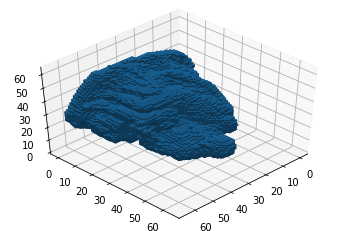

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.view_init(45, 45)
#ax.axis('off')
ax.voxels(Binary_voxel_array)
plt.show()

In [ ]:
# save to npy file
np.savez('/content/drive/MyDrive/data/Artathon_data/Binary_voxel_array.npz', Binary_voxel_array)

### Train the autoencoder 

In [ ]:
import numpy as np


import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import os
import re

import torch.nn.utils.prune as prune



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, voxel_path, transform=None):
        self.voxel_path = voxel_path
        self.transform = None

    def __len__(self):
        return 1

    def __getitem__(self, x):
        # open image here as PIL / numpy
        #image = plt.imread(self.image_path)
        voxel_data = np.load(self.voxel_path)['arr_0']
        voxel_data = voxel_data[None, :, :, :]
        voxel_data = voxel_data.astype(np.float32)

        #voxel_data = TF.to_tensor(voxel_data)
        #s = image.size

        if self.transform is not None:
            image = self.transform(image)

        return voxel_data

In [ ]:
#### CHANGE THE PATH OF THE .npz FILE HERE
dataset = MyDataset('/content/drive/MyDrive/data/Artathon_data/Binary_voxel_array.npz')
#### 

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

In [ ]:
class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :64, :64, :64]


class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 128, 3, stride=2, padding = 1),  # b, 16, 398, 398,
            nn.LeakyReLU(0.01),
            #nn.MaxPool3d(2, stride=2),  # b,  16, 199, 199

            #nn.Conv3d(64, 128, 5, stride=2, padding = 1),  # b, 8, 99, 99
            #nn.ReLU(True),

            #nn.MaxPool3d(2, stride=2)  # b, 8, 49, 49
        )
        self.decoder = nn.Sequential(
            
            #nn.ConvTranspose3d(128, 16, 5, stride=2),
            #nn.ReLU(True),
            
            #nn.Upsample(size=(18, 18, 18), mode='trilinear', align_corners=False),
            nn.ConvTranspose3d(128, 1, 3, stride=2),
            nn.Sigmoid(),
            #nn.MaxUnpool3d(2, stride=2),

            #nn.Upsample(size=(64, 64, 64), mode='trilinear', align_corners=False),

            #nn.ConvTranspose2d(8, 16, 3, stride=2, padding = 0),  # b, 16, 5, 5
            #nn.ReLU(True),
            #nn.ConvTranspose2d(16, 8, 3, stride=2, padding = 0),  # b, 8, 15, 15
            #nn.ReLU(True),
            #nn.ConvTranspose2d(8, 1, 5, stride=2, padding = 0),  # b, 1, 28, 28
            Trim()
            #nn.Sigmoid()
        )

    def forward(self, x):
        x_encoded = self.encoder(x)
        #print(x_encoded.shape)
        x = self.decoder(x_encoded)
        #print(x.shape)

        return x


In [ ]:
model = autoencoder()
criterion = nn.MSELoss()

In [ ]:
num_epochs = 500
batch_size = 1
learning_rate = 0.001


optimizer = torch.optim.Adam(model.parameters(), learning_rate)
total_loss = 0
for epoch in range(num_epochs):
    for data in dataloader:
        img = Variable(data)
        # ===================forward=====================
        output = model(img)
        #output = output > 0.5
        #output = np.array(output)
        #output = output.to(torch.float32)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    total_loss += loss.data
    print('epoch [{}/{}]'
          .format(epoch+1, num_epochs))
    #if epoch % 10 == 0:
    #    pic = output.cpu()#.detach()#.numpy()
    #   save_image(pic, 'image_{}.png'.format(epoch))

#torch.save(model.state_dict(), './conv_autoencoder.pth')

epoch [1/100], loss:0.2135
epoch [2/100], loss:0.4255
epoch [3/100], loss:0.6360
epoch [4/100], loss:0.8451
epoch [5/100], loss:1.0528
epoch [6/100], loss:1.2592
epoch [7/100], loss:1.4641
epoch [8/100], loss:1.6677
epoch [9/100], loss:1.8700
epoch [10/100], loss:2.0709
epoch [11/100], loss:2.2705
epoch [12/100], loss:2.4689
epoch [13/100], loss:2.6660
epoch [14/100], loss:2.8618
epoch [15/100], loss:3.0563
epoch [16/100], loss:3.2496
epoch [17/100], loss:3.4416
epoch [18/100], loss:3.6323
epoch [19/100], loss:3.8219
epoch [20/100], loss:4.0101
epoch [21/100], loss:4.1972
epoch [22/100], loss:4.3829
epoch [23/100], loss:4.5675
epoch [24/100], loss:4.7507
epoch [25/100], loss:4.9328
epoch [26/100], loss:5.1135
epoch [27/100], loss:5.2930
epoch [28/100], loss:5.4711
epoch [29/100], loss:5.6480
epoch [30/100], loss:5.8236
epoch [31/100], loss:5.9980
epoch [32/100], loss:6.1709
epoch [33/100], loss:6.3426
epoch [34/100], loss:6.5130
epoch [35/100], loss:6.6820
epoch [36/100], loss:6.8497
e

### Pruning

In [ ]:
voxel_data = Binary_voxel_array[None, None, :, :, :]
voxel_data = voxel_data.astype(np.float32)
voxel_data = Variable(torch.from_numpy(voxel_data))

In [ ]:
new_autoencoder = model

In [ ]:
# start pruning 
predicted = new_autoencoder(voxel_data)

In [ ]:
predicted = predicted.squeeze(dim = 0)
predicted = predicted.squeeze(dim = 0)

In [ ]:
predicted = predicted > 0.5

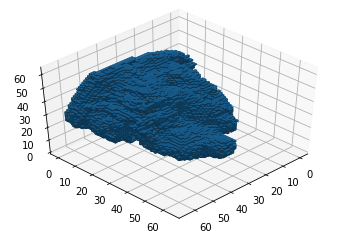

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.view_init(45, 45)
#ax.axis('off')
ax.voxels(predicted)
plt.show()

In [ ]:
print(f'Non Zero Parameters: {sum([torch.sum(p != 0) for p in new_autoencoder.parameters()])}')

Non Zero Parameters: 1588


In [ ]:
parameters_to_prune = [(new_autoencoder.encoder[0], 'weight'),
 (new_autoencoder.decoder[0], 'weight')]

In [ ]:
prune.global_unstructured(parameters_to_prune, pruning_method=prune.L1Unstructured, amount=0.3)
print('Pruning Completed')

Pruning Completed


In [ ]:
for p in parameters_to_prune:
    prune.remove(p[0], p[1])

In [ ]:
print(f'Non Zero Parameters: {sum([torch.sum(p != 0) for p in new_autoencoder.parameters()])}')

Non Zero Parameters: 1243


### Save the output

In [ ]:
from voxelfuse.voxel_model import VoxelModel
from voxelfuse.mesh import Mesh

In [ ]:
def save_voxel(voxel_data, path):
    model = VoxelModel(voxel_data)  
    mesh = Mesh.fromVoxelModel(model)
    mesh.export(path)

In [ ]:
save_voxel(predicted, '/content/drive/MyDrive/data/Artathon_data/pruned30.obj')

Meshing: 100%|██████████| 13812/13812 [00:03<00:00, 3836.27it/s]
